In [1]:
%matplotlib inline

In [26]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from myImageFolder import MyImageFolder
from sklearn.metrics import roc_auc_score, roc_curve
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.RandomAffine(degrees=2, translate=(0.15,0.1),scale=(0.75,1.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.RandomAffine(degrees=2, translate=(0.15,0.1),scale=(0.75,1.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),

    ]),
    'test': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.RandomAffine(degrees=2, translate=(0.15,0.1),scale=(0.75,1.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),

    ]),


}

data_dir = '/home/kaiyihuang/nexperia/new_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [256]:
def process(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image = mpimg.imread(filename)
    # <something gets done here>
    plt.figure()
    plt.imshow(image,cmap='gray')

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, save_path, weight=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc_bad = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
                        
            y_true = []
            y_pred = []
            bad_score = []
            fm_score = []

            # Iterate over data.
            for i,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                encode = lambda label: ecoc[label,:]
                codes = torch.stack([encode(label) for label in labels]).to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    m_1 = nn.Tanh()
                    outputs = m_1(outputs)
                    probs = (outputs + 1.) / 2. * 0.99998 + 0.00001
                    
                    # decide by argmax(M*output), where M is code matrix
                    fun = lambda code: torch.matmul(ecoc, code)
                    sums = torch.stack([fun(outputs[i,:].detach().cpu()) for i in range(outputs.shape[0])])
                    m_2 = nn.Softmax(dim=1)
                    bad_prob = 1-m_2(sums)[:,4]
                    fm_prob = m_2(sums)[:,3]
                    preds = torch.argmax(sums,dim=1)
                    
                    loss = criterion(probs.cpu(), (codes.cpu()+1.)/2.,weight)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.cpu())
                                
                y_true.append(labels.detach().cpu())
                y_pred.append(preds)
                bad_score.append(bad_prob)
                fm_score.append(fm_prob)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            y_true = torch.cat(y_true)
            y_pred = torch.cat(y_pred)
            bad_score = torch.cat(bad_score).numpy()
            fm_score = torch.cat(fm_score).numpy()

            y_bad = (y_true!=4).numpy()
            y_fm = (y_true==3).numpy()
            
            fpr_bad,tpr_bad,thresholds_bad = roc_curve(y_bad, bad_score)
            fpr_fm,tpr_fm,thresholds_fm = roc_curve(y_fm, fm_score)
            
            # tpr_bad>=0.9910
            if np.any(tpr_bad>=0.9910):
                idx_1 = np.arange(tpr_bad.shape[0])[tpr_bad>=0.9910][np.argmin(tpr_bad[tpr_bad>=0.9910])]
            else:
                idx_1 = np.argmax(tpr_bad)
            fpr_bad_991 = fpr_bad[idx_1]
            tpr_bad_991 = tpr_bad[idx_1]
            thr_bad_991 = thresholds_bad[idx_1]
            
            # tpr_bad>=0.9930
            if np.any(tpr_bad>=0.9930):
                idx_2 = np.arange(tpr_bad.shape[0])[tpr_bad>=0.9930][np.argmin(tpr_bad[tpr_bad>=0.9930])]
            else:
                idx_2 = idx_1
            fpr_bad_993 = fpr_bad[idx_2]
            tpr_bad_993 = tpr_bad[idx_2]
            thr_bad_993 = thresholds_bad[idx_2]

            # tpr_bad>=0.9950
            if np.any(tpr_bad>=0.9950):
                idx_3 = np.arange(tpr_bad.shape[0])[tpr_bad>=0.9950][np.argmin(tpr_bad[tpr_bad>=0.9950])]
            else:
                idx_3 = idx_2
            fpr_bad_995 = fpr_bad[idx_3]
            tpr_bad_995 = tpr_bad[idx_3]
            thr_bad_995 = thresholds_bad[idx_3]
            
            # tpr_bad==1
            if np.any(tpr_bad==1.0):
                idx_4 = np.arange(tpr_bad.shape[0])[tpr_bad==1.0][np.argmin(tpr_bad[tpr_bad==1.0])]
            else:
                idx_4 = idx_3
            fpr_bad_1 = fpr_bad[idx_4]
            tpr_bad_1 = tpr_bad[idx_4]
            thr_bad_1 = thresholds_bad[idx_4]
            
            # fpr_bad<=0.10
            if np.any(fpr_bad<=0.1):
                idx_5 = np.arange(fpr_bad.shape[0])[fpr_bad<=0.10][np.argmax(fpr_bad[fpr_bad<=0.10])]
            else:
                idx_5 = np.argmin(fpr_bad)
            fpr_bad_010 = fpr_bad[idx_5]
            tpr_bad_010 = tpr_bad[idx_5]
            thr_bad_010 = thresholds_bad[idx_5]
            
            epoch_auc_bad = roc_auc_score(y_bad, bad_score)
            epoch_auc_fm = roc_auc_score(y_fm, fm_score)

            print('{} Loss: {:.4f} Acc: {:.4f} AUC_bad: {:.4f} AUC_fm {:.4f}'
                  .format(phase, epoch_loss, epoch_acc, epoch_auc_bad, epoch_auc_fm))
            print('{} TPR_bad>=0.9991 TPR: {:.4f} FPR: {:.4f} threshold: {:.4f}'
                 .format(' '*len(phase), tpr_bad_991, fpr_bad_991, thr_bad_991))
            print('{} TPR_bad>=0.9993 TPR: {:.4f} FPR: {:.4f} threshold: {:.4f}'
                 .format(' '*len(phase), tpr_bad_993, fpr_bad_993, thr_bad_993))
            print('{} TPR_bad>=0.9995 TPR: {:.4f} FPR: {:.4f} threshold: {:.4f}'
                 .format(' '*len(phase), tpr_bad_995, fpr_bad_995, thr_bad_995))
            print('{} TPR_bad==1.0 TPR: {:.4f} FPR: {:.4f} threshold: {:.4f}'
                 .format(' '*len(phase), tpr_bad_1, fpr_bad_1, thr_bad_1))
            print('{} FPR_bad<=0.10 TPR: {:.4f} FPR: {:.4f} threshold: {:.4f}'
                 .format(' '*len(phase), tpr_bad_010, fpr_bad_010, thr_bad_010))

            # deep copy the model
            if phase == 'val' and epoch_auc_bad > best_auc_bad:
                best_epoch = epoch
                best_acc = epoch_acc
                best_auc_bad = epoch_auc_bad
                best_auc_fm = epoch_auc_fm
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'val_acc': epoch_acc,
                            'val_loss': epoch_loss,
                            'best_val_auc_bad': epoch_auc_bad,
                            'val_auc_fm': epoch_auc_fm,
                            'val_fpr_bad': fpr_bad,
                            'val_tpr_bad': tpr_bad,
                            'val_thresholds_bad': thresholds_bad,
                            'val_fpr_fm': fpr_fm,
                            'val_tpr_fm': tpr_fm,
                            'val_thresholds_fm': thresholds_fm,
                            'error_correcting_output_code': ecoc
                            }, save_path)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best epoch: {:d}'.format(best_epoch+1))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val AUC_bad: {:4f}'.format(best_auc_bad))
    print('Best val AUC_fm: {:4f}'.format(best_auc_fm))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.



In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 45 (number of ovo cases).
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 45)

model_ft = model_ft.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

code design

In [6]:
C = 10 # number of classes
N = 45 # code length
n=0
ecoc = torch.zeros((C,N))
for i in range(C-1):
    for j in range(i+1,C):
        ecoc[i,n]=1
        ecoc[j,n]=-1
        n+=1

In [12]:
ecoc

tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
          0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
          1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

customized loss function

In [7]:
def weightedBCELoss(output, target, weight=None):
    # output must be NxC vectors between 0 and 1
    
    if not (target.size() == output.size()):
        raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), output.size()))
    
    if weight is not None:
        if not (weight.size()[0] == output.size()[1]):
            raise ValueError("Weight size ({}) must be {} classes".format(weight.size()[0],output.size()[1]))
        loss = torch.mean(-target * weight * torch.log(output) - (1 - target) * torch.log(1 - output))
        
    else:
        loss = torch.mean(-target * torch.log(output) - (1 - target) * torch.log(1 - output))
               
    return loss

In [8]:
criterion = nn.BCELoss()

weights

In [9]:
# code weights
weights = []
for i in range(len(class_names)):
    weight =  sum(class_idx==i for class_idx in image_datasets['train'].targets)
    weights.append(weight)
weight_sum = sum(weights)
code_weights = torch.zeros(N,requires_grad=False)
for i in range(N):
    code_weights[i] = weights[np.argmin(ecoc[:,i])] / weights[np.argmax(ecoc[:,i])]

In [262]:
class_names

['chipping',
 'device_flip',
 'empty_pocket',
 'foreign_material',
 'good',
 'lead_defect',
 'lead_glue',
 'marking_defect',
 'pocket_damage',
 'scratch']

In [10]:
code_weights

tensor([3.6553e-02, 5.5332e-02, 5.3018e-01, 8.2911e+00, 6.9081e-02, 1.7002e-01,
        4.7284e-02, 1.0060e-03, 2.0355e-01, 1.5138e+00, 1.4505e+01, 2.2683e+02,
        1.8899e+00, 4.6514e+00, 1.2936e+00, 2.7523e-02, 5.5688e+00, 9.5818e+00,
        1.4984e+02, 1.2485e+00, 3.0727e+00, 8.5455e-01, 1.8182e-02, 3.6788e+00,
        1.5638e+01, 1.3030e-01, 3.2068e-01, 8.9184e-02, 1.8975e-03, 3.8393e-01,
        8.3320e-03, 2.0506e-02, 5.7030e-03, 1.2134e-04, 2.4551e-02, 2.4612e+00,
        6.8447e-01, 1.4563e-02, 2.9466e+00, 2.7811e-01, 5.9172e-03, 1.1972e+00,
        2.1277e-02, 4.3050e+00, 2.0233e+02])

In [272]:
code_weights[ecoc[5,:]==-1]

tensor([ 0.6908, 18.8991, 12.4848,  1.3030,  0.0833])

In [280]:
code_weights[ecoc[5,:]==1] *= 10
code_weights[ecoc[5,:]==-1] /= 10
code_weights

tensor([3.6553e-02, 5.5332e-02, 5.3018e-01, 8.2911e+00, 6.9081e-03, 1.7002e-01,
        4.7284e-02, 1.0060e-03, 2.0355e-01, 1.5138e+00, 1.4505e+01, 2.2683e+02,
        1.8899e-01, 4.6514e+00, 1.2936e+00, 2.7523e-02, 5.5688e+00, 9.5818e+00,
        1.4984e+02, 1.2485e-01, 3.0727e+00, 8.5455e-01, 1.8182e-02, 3.6788e+00,
        1.5638e+01, 1.3030e-02, 3.2068e-01, 8.9184e-02, 1.8975e-03, 3.8393e-01,
        8.3320e-04, 2.0506e-02, 5.7030e-03, 1.2134e-04, 2.4551e-02, 2.4612e+01,
        6.8447e+00, 1.4563e-01, 2.9466e+01, 2.7811e-01, 5.9172e-03, 1.1972e+00,
        2.1277e-02, 4.3050e+00, 2.0233e+02])

In [279]:
code_weights

tensor([3.6553e-02, 5.5332e-02, 5.3018e-01, 8.2911e+00, 6.9081e-02, 1.7002e-01,
        4.7284e-02, 1.0060e-03, 2.0355e-01, 1.5138e+00, 1.4505e+01, 2.2683e+02,
        1.8899e+00, 4.6514e+00, 1.2936e+00, 2.7523e-02, 5.5688e+00, 9.5818e+00,
        1.4984e+02, 1.2485e+00, 3.0727e+00, 8.5455e-01, 1.8182e-02, 3.6788e+00,
        1.5638e+01, 1.3030e-01, 3.2068e-01, 8.9184e-02, 1.8975e-03, 3.8393e-01,
        8.3320e-03, 2.0506e-02, 5.7030e-03, 1.2134e-04, 2.4551e-02, 2.4612e+00,
        6.8447e-01, 1.4563e-02, 2.9466e+00, 2.7811e-01, 5.9172e-03, 1.1972e+00,
        2.1277e-02, 4.3050e+00, 2.0233e+02])

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 60 min on GPU.





In [11]:
# positive weighted Adam lr=0.0001 take 2
model_ft = train_model(model_ft, weightedBCELoss, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50,save_path='resnet_18_ovo_pos_weighted_Adam_lr_0001_take_2.pt',weight=code_weights)

Epoch 1/50
----------
train Loss: 0.6982 Acc: 0.0003 AUC_bad: 0.9345 AUC_fm 0.8847
      TPR_bad>=0.9991 TPR: 0.9911 FPR: 0.7608 threshold: 0.9967
      TPR_bad>=0.9993 TPR: 0.9930 FPR: 0.8033 threshold: 0.9942
      TPR_bad>=0.9995 TPR: 0.9951 FPR: 0.8537 threshold: 0.9885
      TPR_bad==1.0 TPR: 1.0000 FPR: 0.9992 threshold: 0.8943
      FPR_bad<=0.10 TPR: 0.8372 FPR: 0.0951 threshold: 1.0000
val Loss: 0.6117 Acc: 0.0003 AUC_bad: 0.9892 AUC_fm 0.9730
    TPR_bad>=0.9991 TPR: 0.9914 FPR: 0.1551 threshold: 0.9999
    TPR_bad>=0.9993 TPR: 0.9943 FPR: 0.1780 threshold: 0.9999
    TPR_bad>=0.9995 TPR: 0.9957 FPR: 0.1802 threshold: 0.9999
    TPR_bad==1.0 TPR: 1.0000 FPR: 0.2505 threshold: 0.9989
    FPR_bad<=0.10 TPR: 0.9800 FPR: 0.0994 threshold: 1.0000

Epoch 2/50
----------
train Loss: 0.6231 Acc: 0.0001 AUC_bad: 0.9799 AUC_fm 0.9681
      TPR_bad>=0.9991 TPR: 0.9911 FPR: 0.2584 threshold: 0.9998
      TPR_bad>=0.9993 TPR: 0.9930 FPR: 0.2900 threshold: 0.9996
      TPR_bad>=0.9995 TPR:

In [282]:
# positive weighted Adam lr=0.0001 10 times more penalty on lead defect
model_ft = train_model(model_ft, weightedBCELoss, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50,save_path='resnet_18_ovo_pos_weighted_Adam_lr_0001_ld_10.pt',weight=code_weights)

Epoch 1/50
----------
train Loss: 0.7632 Acc: 0.0051 AUC_bad: 0.9329 AUC_fm 0.8762
      TPR_bad>=0.9991 TPR: 0.9911 FPR: 0.6196 threshold: 0.9895
      TPR_bad>=0.9993 TPR: 0.9930 FPR: 0.6365 threshold: 0.9880
      TPR_bad>=0.9995 TPR: 0.9951 FPR: 0.6870 threshold: 0.9823
      TPR_bad==1.0 TPR: 1.0000 FPR: 0.9884 threshold: 0.8625
      FPR_bad<=0.10 TPR: 0.8150 FPR: 0.0999 threshold: 0.9996
val Loss: 0.6513 Acc: 0.0070 AUC_bad: 0.9873 AUC_fm 0.9588
    TPR_bad>=0.9991 TPR: 0.9914 FPR: 0.1762 threshold: 0.9965
    TPR_bad>=0.9993 TPR: 0.9943 FPR: 0.2108 threshold: 0.9945
    TPR_bad>=0.9995 TPR: 0.9957 FPR: 0.2130 threshold: 0.9943
    TPR_bad==1.0 TPR: 1.0000 FPR: 0.2450 threshold: 0.9916
    FPR_bad<=0.10 TPR: 0.9757 FPR: 0.0976 threshold: 0.9991

Epoch 2/50
----------
train Loss: 0.6614 Acc: 0.0101 AUC_bad: 0.9802 AUC_fm 0.9469
      TPR_bad>=0.9991 TPR: 0.9911 FPR: 0.2623 threshold: 0.9899
      TPR_bad>=0.9993 TPR: 0.9930 FPR: 0.3003 threshold: 0.9838
      TPR_bad>=0.9995 TPR:

In [18]:
# positive weighted Adam lr=0.0001
model_ft = train_model(model_ft, weightedBCELoss, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50,save_path='resnet_18_ovo_pos_weighted_Adam_lr_0001.pt',weight=code_weights)

Epoch 1/50
----------
train Loss: 0.7113 Acc: 0.0050 AUC_bad: 0.9392 AUC_fm 0.8810
      TPR_bad>=0.9991 TPR: 0.9911 FPR: 0.5902 threshold: 0.9888
      TPR_bad>=0.9993 TPR: 0.9930 FPR: 0.6041 threshold: 0.9872
      TPR_bad>=0.9995 TPR: 0.9951 FPR: 0.6452 threshold: 0.9815
      TPR_bad==1.0 TPR: 1.0000 FPR: 0.9711 threshold: 0.7383
      FPR_bad<=0.10 TPR: 0.8349 FPR: 0.0999 threshold: 0.9997
val Loss: 0.6308 Acc: 0.0078 AUC_bad: 0.9798 AUC_fm 0.9428
    TPR_bad>=0.9991 TPR: 0.9914 FPR: 0.3171 threshold: 0.9605
    TPR_bad>=0.9993 TPR: 0.9943 FPR: 0.4216 threshold: 0.9139
    TPR_bad>=0.9995 TPR: 0.9957 FPR: 0.4714 threshold: 0.8899
    TPR_bad==1.0 TPR: 1.0000 FPR: 0.8617 threshold: 0.7298
    FPR_bad<=0.10 TPR: 0.9657 FPR: 0.0968 threshold: 0.9989

Epoch 2/50
----------
train Loss: 0.6263 Acc: 0.0117 AUC_bad: 0.9780 AUC_fm 0.9501
      TPR_bad>=0.9991 TPR: 0.9911 FPR: 0.2876 threshold: 0.9883
      TPR_bad>=0.9993 TPR: 0.9930 FPR: 0.3351 threshold: 0.9789
      TPR_bad>=0.9995 TPR:

In [12]:
# positive weighted Adam
model_ft = train_model(model_ft, weightedBCELoss, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50,save_path='resnet_18_ovo_pos_weighted_Adam.pt',weight=code_weights)

Epoch 1/50
----------
train Loss: 0.6952 Acc: 0.0042 AUC_bad: 0.9169 AUC_fm 0.8254
      TPR_bad>=0.9991 TPR: 0.9911 FPR: 0.6800 threshold: 0.9862
      TPR_bad>=0.9993 TPR: 0.9930 FPR: 0.7267 threshold: 0.9793
      TPR_bad>=0.9995 TPR: 0.9951 FPR: 0.7708 threshold: 0.9686
      TPR_bad==1.0 TPR: 1.0000 FPR: 0.9886 threshold: 0.7292
      FPR_bad<=0.10 TPR: 0.7569 FPR: 0.1000 threshold: 0.9998
val Loss: 1.7856 Acc: 0.0046 AUC_bad: 0.8582 AUC_fm 0.7894
    TPR_bad>=0.9991 TPR: 0.9914 FPR: 0.9625 threshold: 0.6615
    TPR_bad>=0.9993 TPR: 0.9943 FPR: 0.9723 threshold: 0.6607
    TPR_bad>=0.9995 TPR: 0.9957 FPR: 0.9734 threshold: 0.6606
    TPR_bad==1.0 TPR: 1.0000 FPR: 0.9916 threshold: 0.6583
    FPR_bad<=0.10 TPR: 0.6286 FPR: 0.0997 threshold: 0.9497

Epoch 2/50
----------
train Loss: 0.6590 Acc: 0.0063 AUC_bad: 0.9567 AUC_fm 0.8754
      TPR_bad>=0.9991 TPR: 0.9911 FPR: 0.4921 threshold: 0.9822
      TPR_bad>=0.9993 TPR: 0.9930 FPR: 0.5417 threshold: 0.9725
      TPR_bad>=0.9995 TPR:

In [32]:
# positive weighted
model_ft = train_model(model_ft, weightedBCELoss, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50,save_path='resnet_18_ovo_pos_weighted.pt',weight=code_weights)

Epoch 1/50
----------
train Loss: 0.7916 Acc: 0.0039 AUC_bad: 0.8528 AUC_fm 0.7247
      TPR_bad>=0.9991 TPR: 0.9911 FPR: 0.9349 threshold: 0.9903
      TPR_bad>=0.9993 TPR: 0.9930 FPR: 0.9609 threshold: 0.9872
      TPR_bad>=0.9995 TPR: 0.9951 FPR: 0.9903 threshold: 0.9792
      TPR_bad==1.0 TPR: 1.0000 FPR: 1.0000 threshold: 0.8272
      FPR_bad<=0.10 TPR: 0.6169 FPR: 0.0999 threshold: 0.9997
val Loss: 0.7396 Acc: 0.0035 AUC_bad: 0.9634 AUC_fm 0.8648
    TPR_bad>=0.9991 TPR: 0.9914 FPR: 0.4503 threshold: 0.9991
    TPR_bad>=0.9993 TPR: 0.9943 FPR: 0.5002 threshold: 0.9990
    TPR_bad>=0.9995 TPR: 0.9957 FPR: 0.5191 threshold: 0.9989
    TPR_bad==1.0 TPR: 1.0000 FPR: 0.5850 threshold: 0.9986
    FPR_bad<=0.10 TPR: 0.9129 FPR: 0.0994 threshold: 0.9998

Epoch 2/50
----------
train Loss: 0.7131 Acc: 0.0037 AUC_bad: 0.9708 AUC_fm 0.8894
      TPR_bad>=0.9991 TPR: 0.9911 FPR: 0.3696 threshold: 0.9976
      TPR_bad>=0.9993 TPR: 0.9930 FPR: 0.4097 threshold: 0.9970
      TPR_bad>=0.9995 TPR:

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f39904fda70>
Traceback (most recent call last):
  File "/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/multiprocessing/process.py", line 138, in join
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f39904fda70>
Traceback (most recent call last):
  File "/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _sh

val Loss: 0.6532 Acc: 0.0075 AUC_bad: 0.9937 AUC_fm 0.9451
    TPR_bad>=0.9991 TPR: 0.9914 FPR: 0.0917 threshold: 0.9972
    TPR_bad>=0.9993 TPR: 0.9943 FPR: 0.1081 threshold: 0.9957
    TPR_bad>=0.9995 TPR: 0.9957 FPR: 0.1114 threshold: 0.9953
    TPR_bad==1.0 TPR: 1.0000 FPR: 0.1361 threshold: 0.9909
    FPR_bad<=0.10 TPR: 0.9914 FPR: 0.0957 threshold: 0.9970

Epoch 10/50
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f39904fda70>
Traceback (most recent call last):
  File "/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f39904fda70>
Traceback (most recent call last):
  File "/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/hom

train Loss: 0.6539 Acc: 0.0063 AUC_bad: 0.9938 AUC_fm 0.9501
      TPR_bad>=0.9991 TPR: 0.9911 FPR: 0.0758 threshold: 0.9985
      TPR_bad>=0.9993 TPR: 0.9930 FPR: 0.0856 threshold: 0.9980
      TPR_bad>=0.9995 TPR: 0.9951 FPR: 0.1025 threshold: 0.9969
      TPR_bad==1.0 TPR: 1.0000 FPR: 0.6848 threshold: 0.8401
      FPR_bad<=0.10 TPR: 0.9948 FPR: 0.0992 threshold: 0.9972
val Loss: 0.6585 Acc: 0.0070 AUC_bad: 0.9938 AUC_fm 0.9448
    TPR_bad>=0.9991 TPR: 0.9914 FPR: 0.0750 threshold: 0.9978
    TPR_bad>=0.9993 TPR: 0.9943 FPR: 0.0997 threshold: 0.9949
    TPR_bad>=0.9995 TPR: 0.9957 FPR: 0.1798 threshold: 0.9743
    TPR_bad==1.0 TPR: 1.0000 FPR: 0.3018 threshold: 0.9278
    FPR_bad<=0.10 TPR: 0.9929 FPR: 0.0997 threshold: 0.9949

Epoch 11/50
----------
train Loss: 0.6519 Acc: 0.0062 AUC_bad: 0.9942 AUC_fm 0.9516
      TPR_bad>=0.9991 TPR: 0.9911 FPR: 0.0714 threshold: 0.9986
      TPR_bad>=0.9993 TPR: 0.9930 FPR: 0.0811 threshold: 0.9981
      TPR_bad>=0.9995 TPR: 0.9951 FPR: 0.1005 t

In [ ]:
# not weighted
model_ft = train_model(model_ft, weightedBCELoss, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50,save_path='resnet_18_ovo_BCELoss.pt')

Epoch 1/50
----------
train Loss: 0.6432 Acc: 0.2147 AUC_bad: 0.6514 AUC_fm 0.5944
      TPR_bad>=0.9991 TPR: 0.9911 FPR: 0.9748 threshold: 0.5259
      TPR_bad>=0.9993 TPR: 0.9930 FPR: 0.9793 threshold: 0.5196
      TPR_bad>=0.9995 TPR: 0.9952 FPR: 0.9880 threshold: 0.5020
      TPR_bad==1.0 TPR: 1.0000 FPR: 1.0000 threshold: 0.3893
      FPR_bad<=0.10 TPR: 0.2193 FPR: 0.0999 threshold: 0.7870
val Loss: 0.6275 Acc: 0.2681 AUC_bad: 0.8087 AUC_fm 0.6916
    TPR_bad>=0.9991 TPR: 0.9914 FPR: 0.8784 threshold: 0.5587
    TPR_bad>=0.9993 TPR: 0.9943 FPR: 0.8890 threshold: 0.5551
    TPR_bad>=0.9995 TPR: 0.9957 FPR: 0.8897 threshold: 0.5548
    TPR_bad==1.0 TPR: 1.0000 FPR: 0.9330 threshold: 0.5319
    FPR_bad<=0.10 TPR: 0.4714 FPR: 0.0997 threshold: 0.7855

Epoch 2/50
----------
train Loss: 0.6208 Acc: 0.4127 AUC_bad: 0.8324 AUC_fm 0.7423
      TPR_bad>=0.9991 TPR: 0.9911 FPR: 0.8320 threshold: 0.4928
      TPR_bad>=0.9993 TPR: 0.9930 FPR: 0.8419 threshold: 0.4883
      TPR_bad>=0.9995 TPR:

Testing the model
------------------

In [283]:
# Data transformation for testing
data_transforms = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.RandomAffine(degrees=2, translate=(0.15,0.1),scale=(0.75,1.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ])

data_dir = '/home/kaiyihuang/nexperia/new_data/test'
image_datasets = MyImageFolder(data_dir,data_transforms)
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=8,shuffle=True, num_workers=4)
dataset_sizes = len(image_datasets)
class_names = image_datasets.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [284]:
def test_model(model, criterion, save_path):    
    since = time.time()

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    y_true = []
    y_pred = []
    bad_score = []
    fm_score = []
    image_names = []

    # Iterate over data.
    for i,((inputs, labels), names) in enumerate(dataloaders, 0):
        inputs = inputs.to(device)
        labels = labels.to(device)
        encode = lambda label: ecoc[label,:]
        codes = torch.stack([encode(label) for label in labels]).to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            m_1 = nn.Tanh()
            outputs = m_1(outputs)
            probs = (outputs + 1.) / 2. * 0.99998 + 0.00001

            # decide by argmax(M*output), where M is code matrix
            fun = lambda code: torch.matmul(ecoc, code)
            sums = torch.stack([fun(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
            m_2 = nn.Softmax(dim=1)
            bad_prob = 1-m_2(sums)[:,4]
            fm_prob = m_2(sums)[:,3]
            preds = torch.argmax(sums,dim=1)

            loss = criterion(probs.cpu(), (codes.cpu()+1.)/2.)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data.cpu())

        y_true.append(labels.detach().cpu())
        y_pred.append(preds)
        bad_score.append(bad_prob)
        fm_score.append(fm_prob)
        image_names += names

    epoch_loss = running_loss / dataset_sizes
    epoch_acc = running_corrects.double() / dataset_sizes

    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)
    bad_score = torch.cat(bad_score).numpy()
    fm_score = torch.cat(fm_score).numpy()

    y_bad = (y_true!=4).numpy()
    y_fm = (y_true==3).numpy()

    fpr_bad,tpr_bad,thresholds_bad = roc_curve(y_bad, bad_score)
    fpr_fm,tpr_fm,thresholds_fm = roc_curve(y_fm, fm_score)

    # tpr_bad>=0.9910
    if np.any(tpr_bad>=0.9910):
        idx_1 = np.arange(tpr_bad.shape[0])[tpr_bad>=0.9910][np.argmin(tpr_bad[tpr_bad>=0.9910])]
    else:
        idx_1 = np.argmax(tpr_bad)
    fpr_bad_991 = fpr_bad[idx_1]
    tpr_bad_991 = tpr_bad[idx_1]
    thr_bad_991 = thresholds_bad[idx_1]

    # tpr_bad>=0.9930
    if np.any(tpr_bad>=0.9930):
        idx_2 = np.arange(tpr_bad.shape[0])[tpr_bad>=0.9930][np.argmin(tpr_bad[tpr_bad>=0.9930])]
    else:
        idx_2 = idx_1
    fpr_bad_993 = fpr_bad[idx_2]
    tpr_bad_993 = tpr_bad[idx_2]
    thr_bad_993 = thresholds_bad[idx_2]

    # tpr_bad>=0.9950
    if np.any(tpr_bad>=0.9950):
        idx_3 = np.arange(tpr_bad.shape[0])[tpr_bad>=0.9950][np.argmin(tpr_bad[tpr_bad>=0.9950])]
    else:
        idx_3 = idx_2
    fpr_bad_995 = fpr_bad[idx_3]
    tpr_bad_995 = tpr_bad[idx_3]
    thr_bad_995 = thresholds_bad[idx_3]

    # tpr_bad==1
    if np.any(tpr_bad==1.0):
        idx_4 = np.arange(tpr_bad.shape[0])[tpr_bad==1.0][np.argmin(tpr_bad[tpr_bad==1.0])]
    else:
        idx_4 = idx_6
    fpr_bad_1 = fpr_bad[idx_4]
    tpr_bad_1 = tpr_bad[idx_4]
    thr_bad_1 = thresholds_bad[idx_4]

    # fpr_bad<=0.10
    if np.any(fpr_bad<=0.1):
        idx_5 = np.arange(fpr_bad.shape[0])[fpr_bad<=0.10][np.argmax(fpr_bad[fpr_bad<=0.10])]
    else:
        idx_5 = np.argmin(fpr_bad)
    fpr_bad_010 = fpr_bad[idx_5]
    tpr_bad_010 = tpr_bad[idx_5]
    thr_bad_010 = thresholds_bad[idx_5]
    
    # tpr_bad>=0.9970
    if np.any(tpr_bad>=0.9970):
        idx_6 = np.arange(tpr_bad.shape[0])[tpr_bad>=0.9970][np.argmin(tpr_bad[tpr_bad>=0.9970])]
    else:
        idx_6 = idx_3
    fpr_bad_997 = fpr_bad[idx_6]
    tpr_bad_997 = tpr_bad[idx_6]
    thr_bad_997 = thresholds_bad[idx_6]    

    epoch_auc_bad = roc_auc_score(y_bad, bad_score)
    epoch_auc_fm = roc_auc_score(y_fm, fm_score)

    # deep copy the model
    torch.save({
                'model_state_dict': model.state_dict(),
                'test_acc': epoch_acc,
                'test_loss': epoch_loss,
                'test_auc_bad': epoch_auc_bad,
                'test_auc_fm': epoch_auc_fm,
                'test_fpr_bad': fpr_bad,
                'test_tpr_bad': tpr_bad,
                'test_thresholds_bad': thresholds_bad,
                'test_fpr_fm': fpr_fm,
                'test_tpr_fm': tpr_fm,
                'test_thresholds_fm': thresholds_fm,
                'test_bad_score': bad_score,
                'test_fm_score': fm_score,
                'id': np.array(image_names),
                'true_labels': y_true.numpy(),
                'error_correcting_output_code': ecoc
                }, save_path)

    print()

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Loss: {:.4f} Acc: {:.4f} AUC_bad: {:.4f} AUC_fm {:.4f}'
          .format(epoch_loss, epoch_acc, epoch_auc_bad, epoch_auc_fm))
    print('TPR_bad>=0.9991 TPR: {:.4f} FPR: {:.4f} threshold: {:.4f}'
         .format(tpr_bad_991, fpr_bad_991, thr_bad_991))
    print('TPR_bad>=0.9993 TPR: {:.4f} FPR: {:.4f} threshold: {:.4f}'
         .format(tpr_bad_993, fpr_bad_993, thr_bad_993))
    print('TPR_bad>=0.9995 TPR: {:.4f} FPR: {:.4f} threshold: {:.4f}'
         .format(tpr_bad_995, fpr_bad_995, thr_bad_995))
    print('TPR_bad>=0.9997 TPR: {:.4f} FPR: {:.4f} threshold: {:.4f}'
         .format(tpr_bad_997, fpr_bad_997, thr_bad_997))
    print('TPR_bad==1.0 TPR: {:.4f} FPR: {:.4f} threshold: {:.4f}'
         .format(tpr_bad_1, fpr_bad_1, thr_bad_1))
    print('FPR_bad<=0.10 TPR: {:.4f} FPR: {:.4f} threshold: {:.4f}'
         .format( tpr_bad_010, fpr_bad_010, thr_bad_010))

In [236]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 35.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 45)

model_ft = model_ft.to(device)

model_dict = torch.load('resnet_18_ovo_pos_weighted_Adam.pt')

model_wts = model_dict['model_state_dict']

model_ft.load_state_dict(model_wts)

<All keys matched successfully>

In [298]:
# positive weighted Adam lr=0.0001 10 times more penalty on lead defect
test_model(model_ft, weightedBCELoss,
           save_path='test_resnet_18_ovo_pos_weighted_Adam_lr_0001_ld_10.pt')


Testing complete in 0m 6s
Loss: 1.2529 Acc: 0.7282 AUC_bad: 0.9953 AUC_fm 0.9810
TPR_bad>=0.9991 TPR: 0.9910 FPR: 0.0328 threshold: 0.9975
TPR_bad>=0.9993 TPR: 0.9936 FPR: 0.0580 threshold: 0.9678
TPR_bad>=0.9995 TPR: 0.9961 FPR: 0.1330 threshold: 0.6747
TPR_bad>=0.9997 TPR: 0.9974 FPR: 0.1746 threshold: 0.5915
TPR_bad==1.0 TPR: 1.0000 FPR: 0.2654 threshold: 0.4687
FPR_bad<=0.10 TPR: 0.9936 FPR: 0.0662 threshold: 0.9424


In [299]:
result = torch.load('test_resnet_18_ovo_pos_weighted_Adam_lr_0001_ld_10.pt')
names = result['id']
bad_score = result['test_bad_score']
labels = result['true_labels']

In [330]:
np.nonzero(np.logical_and(labels!=4, bad_score<=0.9975))

(array([ 975,  986, 1849, 2655, 2777, 3466, 3509]),)

975
986
1849
2655
2777
3466
3509


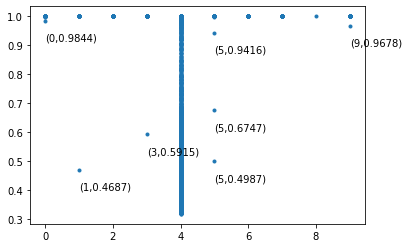

In [334]:
plt.plot(labels, bad_score,'.');
for i in np.nonzero(np.logical_and(labels!=4, bad_score<=0.9975))[0]:
    print(i)
    plt.annotate('({:d},{:.4f})'.format(labels[i],bad_score[i]), # this is the text
                 (labels[i],bad_score[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center

In [309]:
true_good = names[np.logical_and(labels==4, bad_score<=0.4687)]
true_good.shape

(2242,)

In [315]:
names['chipping' in names]

array([], shape=(0, 3830), dtype='<U98')

In [324]:
suspected_good = names[np.logical_and(labels!=4, bad_score<=0.9975)]

In [327]:
np.nonzero(np.logical_and(labels!=4, bad_score<=0.9975))

(array([ 975,  986, 1849, 2655, 2777, 3466, 3509]),)

In [307]:
suspected_bad = names[np.logical_and(labels==4, bad_score>0.9975)]

In [322]:
true_bad = names[np.logical_and(labels!=4, bad_score>=0.4687)]

/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93816052A_41-APG_ITIS_H56_1_24_4.bmp
/home/kaiyihuang/nexperia/new_data/test/foreign_material/WEP93224492A_01-APG_ITIS_H53_1_890_4.bmp
/home/kaiyihuang/nexperia/new_data/test/chipping/WEL93528711A_09-APG_ITIS_H115_1_323_2.bmp
/home/kaiyihuang/nexperia/new_data/test/foreign_material/WEP93740784A_01-APG_ITIS_H44_1_335_1.bmp
/home/kaiyihuang/nexperia/new_data/test/foreign_material/WEP93724952A_21-APG_ITIS_H112_2_193_3.bmp
/home/kaiyihuang/nexperia/new_data/test/chipping/WEP936359D1A_06-APG_ITIS_H49_1_168_4.bmp
/home/kaiyihuang/nexperia/new_data/test/scratch/WEP93331211A_03-APG_ITIS_H09_2_74_3.bmp
/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP934134A4A_16-APG_ITIS_H13_1_172_1.bmp
/home/kaiyihuang/nexperia/new_data/test/lead_glue/WEP93205914A_03-APG_ITIS_H53_2_1115_1.bmp
/home/kaiyihuang/nexperia/new_data/test/foreign_material/WEP93203361A_07-APG_ITIS_H35_2_1246_1.bmp


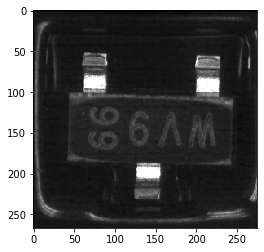

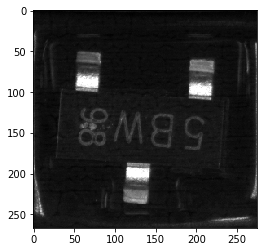

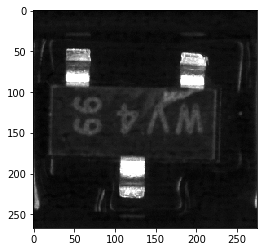

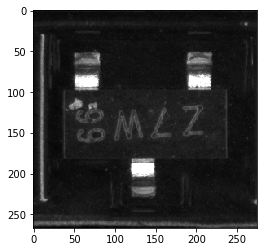

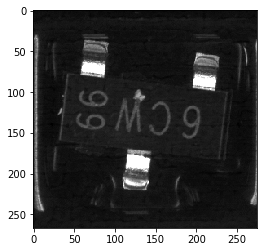

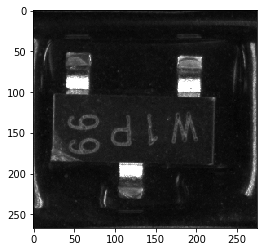

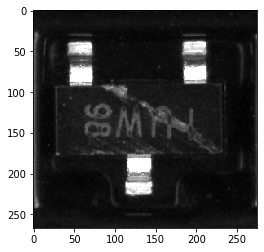

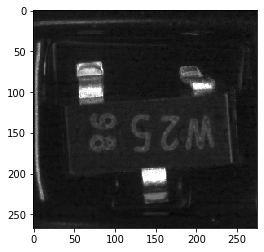

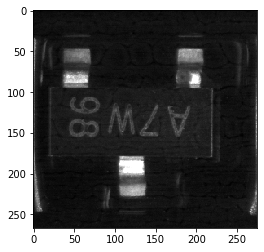

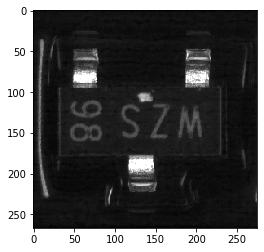

In [323]:
for file in true_bad[120:130]:
    process(file)

/home/kaiyihuang/nexperia/new_data/test/good/WEP93724114A_41-5CW-ITISA51-2_37_3.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEL927267D5A_08-WCM-ITISA52-2_38_1.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEL93514258A_11-1FW-ITISA13-1_174_1.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEL93524816A_40-3BW-ITISA52-1_186_4.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP937068H3A_16-5CW-ITISA45-1_325_2.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEL927267D5A_25-WCM-ITISA52-1_283_2.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP93714412A_16-WDV-ITISA50-2_275_1.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP93714111A_02-TXW-ITISA45-2_571_1.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEL93514258A_48-1FW-ITISA13-1_52_2.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEL927267D5A_20-WCM-ITISA53-2_120_4.bmp


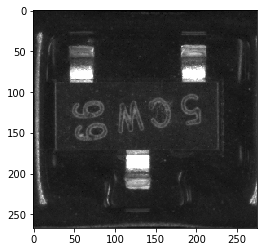

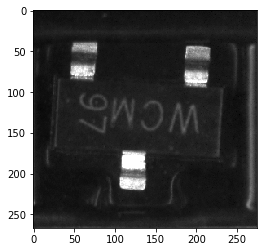

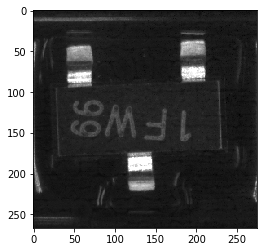

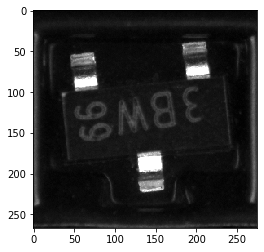

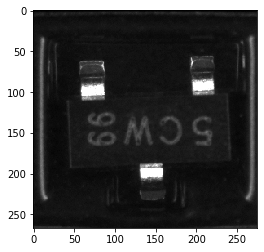

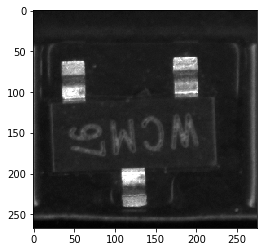

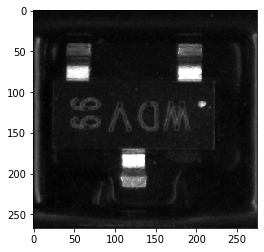

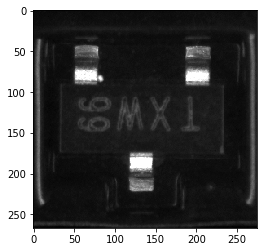

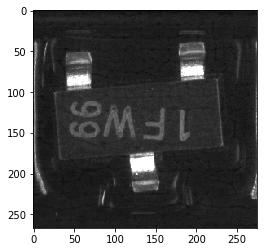

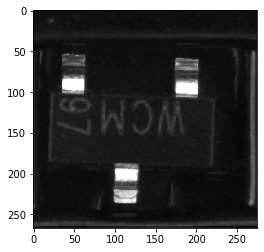

In [310]:
for file in true_good[:10]:
    process(file)




/home/kaiyihuang/nexperia/new_data/test/good/WEP937023H2A_01-A4W-ITISA46-1_249_3.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP93706813A_21-5CW-ITISA49-1_228_4.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP93714312A_05-TVW-ITISA75-1_70_2.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEL92208756A_01-U3W-ITISA09-2_272_4.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP93729814A_41-5BW-ITISA50-1_355_3.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP93724112A_02-5CW-ITISA50-2_68_1.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP93739454A_12-WZS-ITISA73-2_358_3.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEL93539115A_50-A4W-ITISA52-2_166_2.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP93714414A_12-WDV-ITISA75-1_293_3.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEL92208756A_01-U3W-ITISA09-1_337_4.bmp


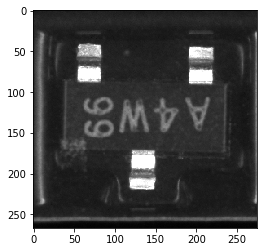

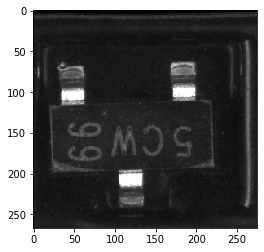

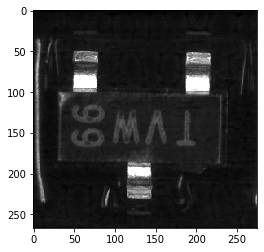

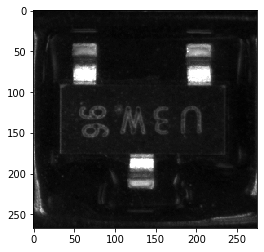

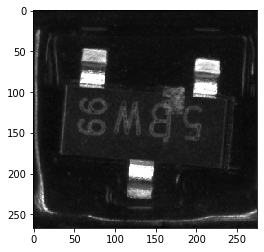

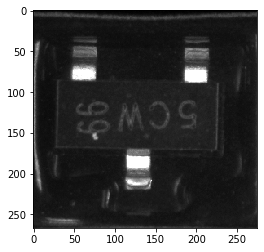

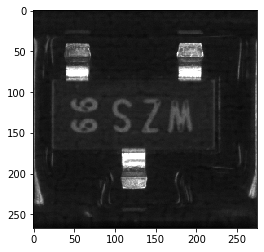

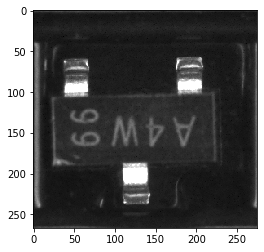

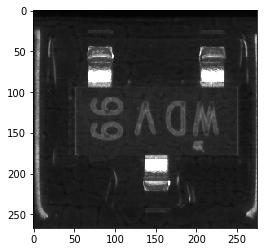

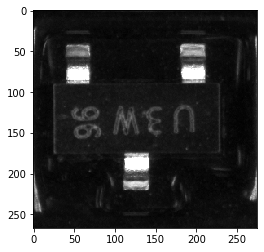

In [306]:
for file in suspected_bad[:10]:
    process(file)



In [ ]:
im = Image.open("/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93724782A_01-APG_ITIS_H57_2_17_1.bmp")

# create rectangle image 
img1 = ImageDraw.Draw(im)   
img1.rectangle([(53,38),(96,84)], outline ="white") 
display(im)

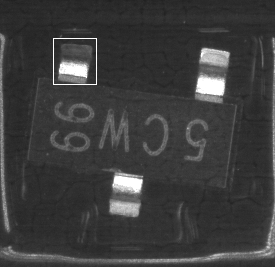

In [25]:
im = Image.open("/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93724782A_01-APG_ITIS_H57_2_17_1.bmp")

# create rectangle image 
img1 = ImageDraw.Draw(im)   
img1.rectangle([(53,38),(96,84)], outline ="white") 
display(im)

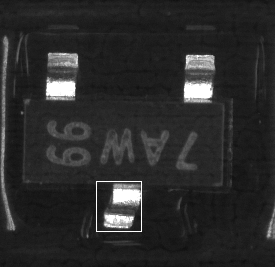

In [27]:
im = Image.open("/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93803811A_44-APG_ITIS_H73_2_72_1.bmp")

# create rectangle image 
img1 = ImageDraw.Draw(im)   
img1.rectangle([(96,181),(141,231)], outline ="white") 
display(im)

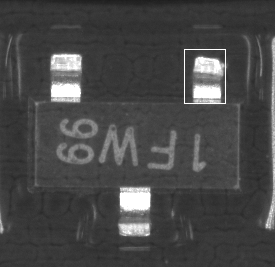

In [28]:
im = Image.open("/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEL93514258A_55-APG_ITIS_H09_1_67_3.bmp")

# create rectangle image 
img1 = ImageDraw.Draw(im)   
img1.rectangle([(184,49),(225,103)], outline ="white") 
display(im)

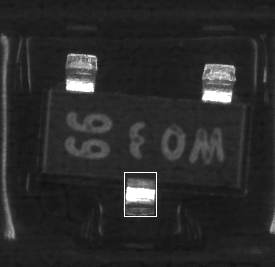

In [29]:
im = Image.open("/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93415394A_49-APG_ITIS_H73_2_50_3.bmp")

# create rectangle image 
img1 = ImageDraw.Draw(im)   
img1.rectangle([(124,172),(156,216)], outline ="white") 
display(im)

In [ ]:
im = Image.open("/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93415394A_49-APG_ITIS_H73_2_50_3.bmp")

# create rectangle image 
img1 = ImageDraw.Draw(im)   
img1.rectangle([(124,172),(156,216)], outline ="white") 
display(im)

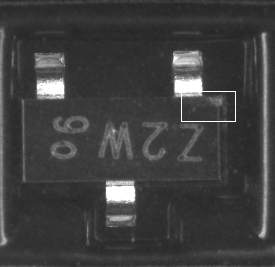

In [31]:
im = Image.open("/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93855011A_01-APG_ITIS_H46_1_76_4.bmp")

# create rectangle image 
img1 = ImageDraw.Draw(im)   
img1.rectangle([(181,91),(235,121)], outline ="white") 
display(im)

In [ ]:
im = Image.open("/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93855011A_01-APG_ITIS_H46_1_76_4.bmp")

# create rectangle image 
img1 = ImageDraw.Draw(im)   
img1.rectangle([(181,91),(235,121)], outline ="white") 
display(im)

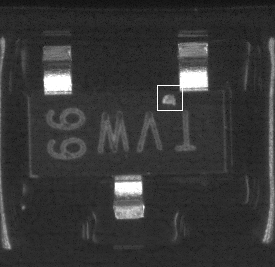

In [32]:
im = Image.open("/home/kaiyihuang/nexperia/new_data/test/foreign_material/WEP93713712A_12-APG_ITIS_H43_2_278_3.bmp")

# create rectangle image 
img1 = ImageDraw.Draw(im)   
img1.rectangle([(157,85),(182,110)], outline ="white") 
display(im)

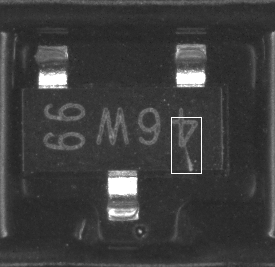

In [33]:
im = Image.open("/home/kaiyihuang/nexperia/new_data/test/scratch/WEP93834612A_03-APG_ITIS_H51_2_204_2.bmp")

# create rectangle image 
img1 = ImageDraw.Draw(im)   
img1.rectangle([(171,117),(201,173)], outline ="white") 
display(im)

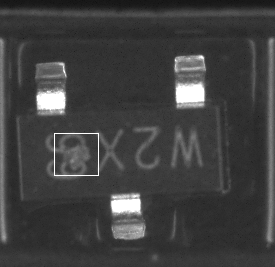

In [34]:
im = Image.open("/home/kaiyihuang/nexperia/new_data/test/scratch/WEP938425D5A_01-APG_ITIS_H52_2_397_2.bmp")

# create rectangle image 
img1 = ImageDraw.Draw(im)   
img1.rectangle([(54,133),(98,175)], outline ="white") 
display(im)

/home/kaiyihuang/nexperia/new_data/test/device_flip/WEP93509812A_21-APG_ITIS_H49_1_214_2.bmp
/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEL93514258A_55-APG_ITIS_H09_1_67_3.bmp
/home/kaiyihuang/nexperia/new_data/test/foreign_material/WEP93713712A_12-APG_ITIS_H43_2_278_3.bmp
/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93855011A_01-APG_ITIS_H46_1_76_4.bmp
/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93724782A_01-APG_ITIS_H57_2_17_1.bmp
/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93803811A_44-APG_ITIS_H73_2_72_1.bmp
/home/kaiyihuang/nexperia/new_data/test/scratch/WEP93834612A_03-APG_ITIS_H51_2_204_2.bmp


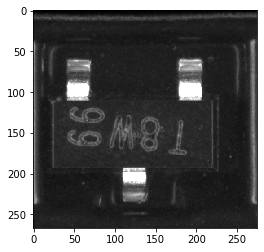

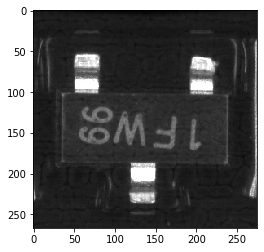

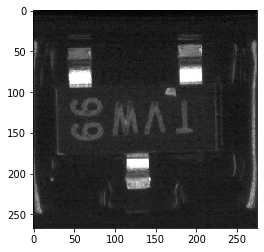

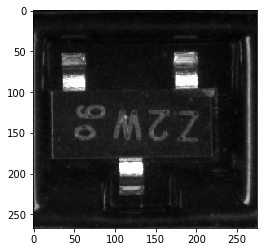

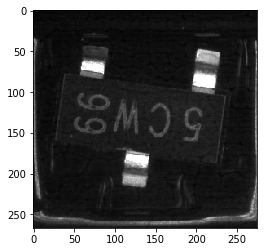

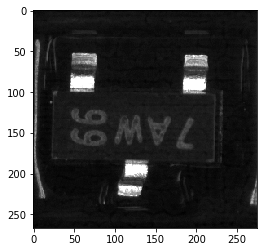

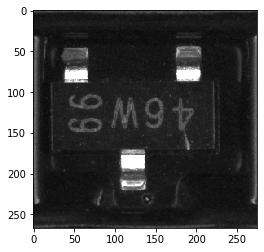

In [325]:
def process(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image = mpimg.imread(filename)
    # <something gets done here>
    plt.figure()
    plt.imshow(image,cmap='gray')
    print(filename)

for file in suspected_good:
    process(file)

# /home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93415394A_49-APG_ITIS_H73_2_50_3.bmp
# /home/kaiyihuang/nexperia/new_data/test/chipping/WEP93855011A_01-APG_ITIS_H46_1_76_4.bmp
# /home/kaiyihuang/nexperia/new_data/test/device_flip/WEP93509812A_21-APG_ITIS_H49_1_214_2.bmp
# /home/kaiyihuang/nexperia/new_data/test/lead_defect/WEL93514258A_55-APG_ITIS_H09_1_67_3.bmp
# /home/kaiyihuang/nexperia/new_data/test/scratch/WEP938425D5A_01-APG_ITIS_H52_2_397_2.bmp
# /home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93803811A_44-APG_ITIS_H73_2_72_1.bmp
# /home/kaiyihuang/nexperia/new_data/test/foreign_material/WEP93713712A_12-APG_ITIS_H43_2_278_3.bmp
# /home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93724782A_01-APG_ITIS_H57_2_17_1.bmp

In [70]:
# not weighted
test_model(model_ft, weightedBCELoss,
           save_path='test_resnet_18_ovo.pt')


Testing complete in 0m 6s
Loss: 0.5878 Acc: 0.8094 AUC_bad: 0.9832 AUC_fm 0.8793
TPR_bad>=0.9991 TPR: 0.9910 FPR: 0.2923 threshold: 0.4314
TPR_bad>=0.9993 TPR: 0.9936 FPR: 0.3627 threshold: 0.4116
TPR_bad>=0.9995 TPR: 0.9961 FPR: 0.4482 threshold: 0.3958
TPR_bad>=0.9997 TPR: 0.9974 FPR: 0.4528 threshold: 0.3950
TPR_bad==1.0 TPR: 1.0000 FPR: 0.7962 threshold: 0.3576
FPR_bad<=0.10 TPR: 0.9627 FPR: 0.0996 threshold: 0.5871


In [78]:
# positive weighted
test_model(model_ft, weightedBCELoss,
           save_path='test_resnet_18_ovo_pos_weighted.pt')


Testing complete in 0m 6s
Loss: 1.3442 Acc: 0.0073 AUC_bad: 0.9938 AUC_fm 0.9527
TPR_bad>=0.9991 TPR: 0.9910 FPR: 0.1065 threshold: 0.9872
TPR_bad>=0.9993 TPR: 0.9936 FPR: 0.1569 threshold: 0.9678
TPR_bad>=0.9995 TPR: 0.9961 FPR: 0.1727 threshold: 0.9626
TPR_bad>=0.9997 TPR: 0.9974 FPR: 0.3008 threshold: 0.9126
TPR_bad==1.0 TPR: 1.0000 FPR: 0.6491 threshold: 0.8170
FPR_bad<=0.10 TPR: 0.9897 FPR: 0.0819 threshold: 0.9942


In [86]:
# positive weighted Adam
test_model(model_ft, weightedBCELoss,
           save_path='test_resnet_18_ovo_pos_weighted_Adam.pt')


Testing complete in 0m 6s
Loss: 1.1887 Acc: 0.4554 AUC_bad: 0.9911 AUC_fm 0.9703
TPR_bad>=0.9991 TPR: 0.9923 FPR: 0.0511 threshold: 0.9992
TPR_bad>=0.9993 TPR: 0.9936 FPR: 0.0524 threshold: 0.9991
TPR_bad>=0.9995 TPR: 0.9961 FPR: 0.3984 threshold: 0.6091
TPR_bad>=0.9997 TPR: 0.9974 FPR: 0.4567 threshold: 0.5770
TPR_bad==1.0 TPR: 1.0000 FPR: 0.6809 threshold: 0.4808
FPR_bad<=0.10 TPR: 0.9923 FPR: 0.0524 threshold: 0.9991


In [215]:
# positive weighted Adam lr=0.0001
test_model(model_ft, weightedBCELoss,
            save_path='test_resnet_18_ovo_pos_weighted_Adam_lr_0001.pt')


Testing complete in 0m 7s
Loss: 1.1507 Acc: 0.7018 AUC_bad: 0.9954 AUC_fm 0.9752
TPR_bad>=0.9991 TPR: 0.9910 FPR: 0.0537 threshold: 0.9377
TPR_bad>=0.9993 TPR: 0.9936 FPR: 0.0642 threshold: 0.9031
TPR_bad>=0.9995 TPR: 0.9961 FPR: 0.1376 threshold: 0.6626
TPR_bad>=0.9997 TPR: 0.9974 FPR: 0.2605 threshold: 0.5236
TPR_bad==1.0 TPR: 1.0000 FPR: 0.4417 threshold: 0.4577
FPR_bad<=0.10 TPR: 0.9936 FPR: 0.0911 threshold: 0.7992


In [216]:
result = torch.load('test_resnet_18_ovo_pos_weighted_Adam_lr_0001.pt')
names = result['id']
bad_score = result['test_bad_score']
labels = result['true_labels']

In [259]:
suspected_good = names[np.logical_and(labels!=4, bad_score<=0.9377)]
print(suspected_good)
print(suspected_good.shape)

['/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93415394A_49-APG_ITIS_H73_2_50_3.bmp'
 '/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93855011A_01-APG_ITIS_H46_1_76_4.bmp'
 '/home/kaiyihuang/nexperia/new_data/test/device_flip/WEP93509812A_21-APG_ITIS_H49_1_214_2.bmp'
 '/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEL93514258A_55-APG_ITIS_H09_1_67_3.bmp'
 '/home/kaiyihuang/nexperia/new_data/test/scratch/WEP938425D5A_01-APG_ITIS_H52_2_397_2.bmp'
 '/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93803811A_44-APG_ITIS_H73_2_72_1.bmp'
 '/home/kaiyihuang/nexperia/new_data/test/foreign_material/WEP93713712A_12-APG_ITIS_H43_2_278_3.bmp'
 '/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93724782A_01-APG_ITIS_H57_2_17_1.bmp']
(8,)


/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93415394A_49-APG_ITIS_H73_2_50_3.bmp
/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93855011A_01-APG_ITIS_H46_1_76_4.bmp
/home/kaiyihuang/nexperia/new_data/test/device_flip/WEP93509812A_21-APG_ITIS_H49_1_214_2.bmp
/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEL93514258A_55-APG_ITIS_H09_1_67_3.bmp
/home/kaiyihuang/nexperia/new_data/test/scratch/WEP938425D5A_01-APG_ITIS_H52_2_397_2.bmp
/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93803811A_44-APG_ITIS_H73_2_72_1.bmp
/home/kaiyihuang/nexperia/new_data/test/foreign_material/WEP93713712A_12-APG_ITIS_H43_2_278_3.bmp
/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93724782A_01-APG_ITIS_H57_2_17_1.bmp


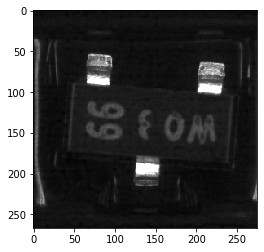

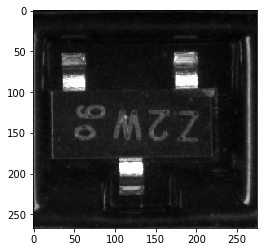

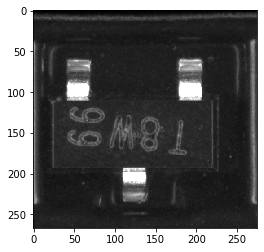

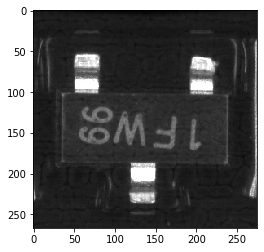

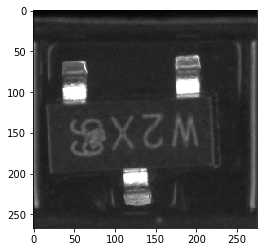

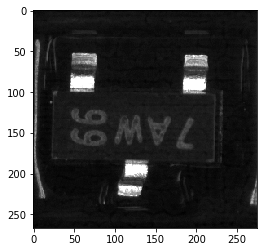

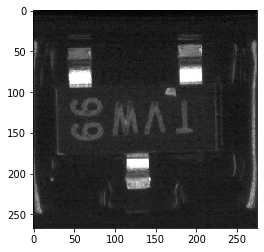

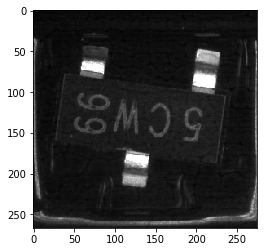

In [260]:
def process(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image = mpimg.imread(filename)
    # <something gets done here>
    plt.figure()
    plt.imshow(image,cmap='gray')
    print(filename)

for file in suspected_good:
    process(file)

In [205]:
image_names = []
Image.open(suspected_good[1])Image.open(suspected_good[1])Image.open(suspected_good[1])Image.open(suspected_good[1])Image.open(suspected_good[1])
# Iterate over data.
for i,((inputs, labels), names) in enumerate(dataloaders, 0):
    image_names += names
    if i==3:
        break

In [208]:
np.array(image_names).shape

(32,)